<a href="https://colab.research.google.com/github/MJMortensonWarwick/ADA/blob/main/2_1_cnn_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks and Transfer Learning (Fine Tuning)
This tutorial will start by walking through a custom-built CNN in Keras. We will be working with a chest x-ray set from Kaggle ([here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)) where we are predicting whether a paitent has pneumonia or not.

To get the data we need an API key from Kaggle. Set up an account (if you haven't got one already) and then click on your avatar in the top right and "Account" from the dropdown menu. Scroll down the page and you'll find a button to "Create New API Token". This downloads an API key to your PC which you can upload here.

In [27]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"mjmortenson","key":"8eecfe5273369a148b04450f0c448fb5"}'}

Next we need to move this to a folder called kaggle as this is where Colab will look (Linux commands):

In [28]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

## Data Extraction
Now you can download the data. The following can be used for any Kaggle dataset. When you are on the dataset page click the three vertical dots on the right and select "Copy API command". This gives you code that looks like below (but add a "!" at the start):

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

This has added the data as a zip folder. We can unzip it and create a new folder (Linux again):

In [ ]:
!unzip chest-xray-pneumonia.zip -d chest-xray-pneumonia

For ease we will create some variables to store the path to the directories:

In [ ]:
train_dir = "/content/chest-xray-pneumonia/chest_xray/train"
test_dir = "/content/chest-xray-pneumonia/chest_xray/test"
val_dir = "/content/chest-xray-pneumonia/chest_xray/val"

## Data Augmentations
Now we can add a generator to create augmentations.

For test and validation we just want to normalise (divide by 255 pixels). For the training you have some additional choices! Which of the augmentations would be appropriate for our problem? What values should you choose if so? These are ultimately domain questions we need to consider,

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# delete the '#' for any augmentation you want to include. Also add the chosen value to replace {ENTER}.
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   #rotation_range = {ENTER}, # set the number of degrees to rotate either side.
                                   #zoom_range = {ENTER}, # what % zooming should occur
                                   #width_shift_range = {ENTER}, # what % left or right shifting should occur
                                   #height_shift_range = {ENTER}, # what % up or down shifting should occur
                                   #horizontal_flip = {ENTER}, # flip the image as a mirror - True or False
                                   #vertical_flip = {ENTER} # flip the image upside down - True or False
                                   )
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

Finally we can create our dataset variables with a batch size of 16. We'll also shrink down the images to 64x64 pixels:

In [33]:
batch_size = 16
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (64, 64),
                                                 batch_size = batch_size,
                                                 class_mode = "binary")
val_set = val_datagen.flow_from_directory(val_dir,
                                          target_size = (64, 64),
                                          batch_size = batch_size,
                                          class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Custom Convolutional Neural Network
Now we can build our model:

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

cnn = Sequential() # again we add as a sequence as this is feed forward

In [35]:
# add each layer in sequence
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(64, 64, 3))) # input is 64x64 images in 3 channels
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=2, strides=2, padding='SAME'))
cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=2, strides=2, padding='SAME'))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(1, activation='sigmoid')) # 1 neuron as binary prediction

In [36]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_5 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_6 (Bat  (None, 29, 29, 64)        256       
 chNormalization)                                                
                                                      

Nearly a million parameters to learn! We better get busy:

In [37]:
from keras import losses

cnn.compile(optimizer = 'adam',
            loss = losses.BinaryCrossentropy(),
            metrics = ['Recall'])

history = cnn.fit(training_set, validation_data = val_set, epochs = 10)

Epoch 1/10
326/326 [==============================] - 84s 253ms/step - loss: 0.2476 - recall: 0.9535 - val_loss: 4.5796 - val_recall: 1.0000
Epoch 2/10
326/326 [==============================] - 84s 257ms/step - loss: 0.1331 - recall: 0.9680 - val_loss: 0.3741 - val_recall: 0.7500
Epoch 3/10
326/326 [==============================] - 81s 249ms/step - loss: 0.0909 - recall: 0.9763 - val_loss: 0.4387 - val_recall: 1.0000
Epoch 4/10
326/326 [==============================] - 83s 254ms/step - loss: 0.0920 - recall: 0.9788 - val_loss: 1.7013 - val_recall: 0.3750
Epoch 5/10
326/326 [==============================] - 81s 247ms/step - loss: 0.0728 - recall: 0.9827 - val_loss: 0.4000 - val_recall: 1.0000
Epoch 6/10
326/326 [==============================] - 81s 248ms/step - loss: 0.0676 - recall: 0.9822 - val_loss: 0.9276 - val_recall: 1.0000
Epoch 7/10
326/326 [==============================] - 80s 246ms/step - loss: 0.0691 - recall: 0.9840 - val_loss: 1.6331 - val_recall: 1.0000
Epoch 8/10
32

## Results
Let's visualise the results:

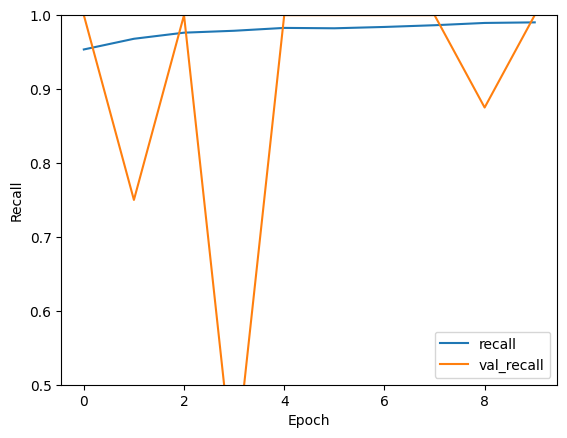

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

We can see recall on the training set has steadily improved. On the validation set its all over the place but then that's only 16 images. Let's see how we do on test:

In [39]:
test_loss, test_recall = cnn.evaluate(test_set)

39/39 [==============================] - 6s 157ms/step - loss: 2.2023 - recall: 0.9949


99% recall and relatively small loss (cross entropy). Our model seems to do pretty well ... but, would it be better if we tried transfer learning?

## Transfer Learning (Fine Tuning)
Now we will try transfer learning from a backbone model - the modern update of CNNs [EfficientNet](https://arxiv.org/abs/1905.11946).

We will import the model, change the input shape (64x64 as before with 3 channels ... more on this later) and use the initial learned from the imagenet dataset to make a backbone feature extractor.

Note we use _include\_top=False_ to remove the classifier from the top. You can then replace this with your own classifier model!

In [45]:
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import GlobalAveragePooling2D

backbone = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(64, 64, 3))

# Freeze the pretrained weights
backbone.trainable = False

# build a classifier on top
# note the input here is the backbone output (the feature extractor) not a normal input layer
x = GlobalAveragePooling2D(name="avg_pool")(backbone.output)
x = BatchNormalization()(x) # our input for this new layer is 'x' - the previous layer

# add any further layers here in the same manor
# list each as 'x = ...'
# and add '(x)' to the end each time

outputs = Dense(1, activation='sigmoid')(x)


Note, however, that EfficientNet assumes an RGB input rather than the greyscale input we are working with. This is easily fixed by tweaking our flow from directory code:

In [46]:
batch_size = 16
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (64, 64),
                                                 color_mode = "rgb", # change colour mode
                                                 batch_size = batch_size,
                                                 class_mode = "binary")
val_set = val_datagen.flow_from_directory(val_dir,
                                          target_size = (64, 64),
                                          color_mode = "rgb",
                                          batch_size = batch_size,
                                          class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (64, 64),
                                            color_mode = "rgb",
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


And then we can train the model as before:

In [47]:
from keras import losses, Model
from keras.optimizers import Adam
from keras.layers import Input

optimiser = Adam(learning_rate=1e-2) # lower learning rate

enet = Model(backbone.input, outputs)

enet.compile(optimizer = optimiser,
            loss = losses.BinaryCrossentropy(),
            metrics = ['Recall'])

history_two = enet.fit(training_set, validation_data = val_set, epochs = 5) # 5 epochs to save time

Epoch 1/5
326/326 [==============================] - 87s 244ms/step - loss: 0.6840 - recall: 0.8808 - val_loss: 0.6995 - val_recall: 1.0000
Epoch 2/5
326/326 [==============================] - 72s 222ms/step - loss: 0.5853 - recall: 0.9210 - val_loss: 1.0619 - val_recall: 1.0000
Epoch 3/5
326/326 [==============================] - 73s 223ms/step - loss: 0.5469 - recall: 0.9399 - val_loss: 1.0611 - val_recall: 1.0000
Epoch 4/5
326/326 [==============================] - 73s 223ms/step - loss: 0.5423 - recall: 0.9394 - val_loss: 0.8768 - val_recall: 1.0000
Epoch 5/5
326/326 [==============================] - 72s 220ms/step - loss: 0.5211 - recall: 0.9306 - val_loss: 0.9758 - val_recall: 1.0000


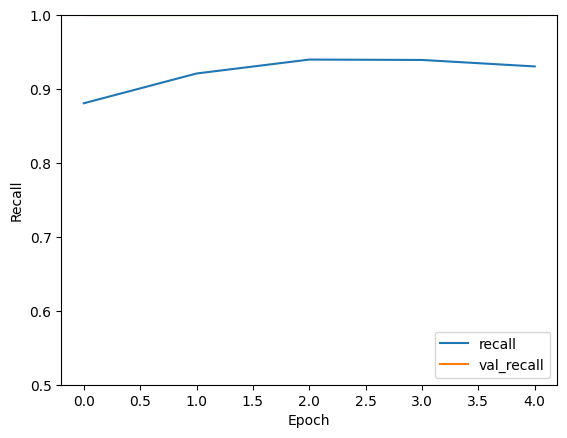

In [48]:
plt.plot(history_two.history['recall'], label='recall')
plt.plot(history_two.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Your results may vary from this depending on the layers you have added and the augmentations selected. We can end by evaluating the test set:

In [49]:
test_loss, test_recall = enet.evaluate(test_set)

39/39 [==============================] - 9s 235ms/step - loss: 0.7001 - recall: 1.0000


Again, results may differ, but mine are certainly better! Well done transfer learning 👍